### Zero-Few Shot
Comparison between a standard GPT2 model and the same model after been fineTuned with 90k matches

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import os

#Standard GPT2: Tokenizer and model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


model = GPT2LMHeadModel.from_pretrained("gpt2", trust_remote_code=True)
model.eval()


# Fine-tuned GPT2: Tokenizer1 and model1
model_path = "../ChessBOT_GPT2/Model90K/model" #Modify as soon the model made it to HuggingFace
tokenizer1 = GPT2Tokenizer.from_pretrained(model_path,use_safetensors=True)
if tokenizer1.pad_token is None:
    tokenizer1.pad_token = tokenizer1.eos_token

model1 = GPT2LMHeadModel.from_pretrained(model_path,use_safetensors=True,trust_remote_code=True)
model1.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

#### Utils

In [ ]:
def generate_text(model,tokenizer,prompt, max_new_tokens=100, temperature=0.7, top_k=50, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    prompt_length = len(inputs["input_ids"][0])
    
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],  
            max_length=prompt_length + max_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id  
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    new_text = generated_text[len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)):]
    
    return new_text.strip()

In [2]:
import chess
## if starting_fen is None, the board will be initialized to the starting position 
def get_fen_from_uci_sequence(uci_sequence, starting_fen=None):

    
    if starting_fen:
        board = chess.Board(starting_fen)
    else:
        board = chess.Board()  
    
    moves = uci_sequence.strip().split()
    
    for move_str in moves:
        
        try:
            move = chess.Move.from_uci(move_str)
            
            if move in board.legal_moves:
                board.push(move)

            else:
                print(f"Moves {move_str} not legal!")
                print("Moves sequence was interrupted.")
                break
        except ValueError:
            print(f"Moves {move_str} not in UCI format!")
            print("Moves sequence was interrupted.")
            break
    
    # Stampa la scacchiera nello stato attuale
    print("\nState of the board:")
    print(board)
    
    # Ritorna la FEN finale
    final_fen = board.fen()
    print(f"\nFEN: {final_fen}")
    
    return final_fen, board

#### Status
Selection of the Hystory of the game from the start

In [15]:
movesHistory="c2c4 c7c5 b1a3 g8f6 d2d3 d7d6 a3b5 g7g6 c1h6 f8g7 h6g7 c8g4 b5d4"

FEN,board=get_fen_from_uci_sequence(movesHistory)


State of the board:
r n . q k . . r
p p . . p p B p
. . . p . n p .
. . p . . . . .
. . P N . . b .
. . . P . . . .
P P . . P P P P
R . . Q K B N R

FEN: rn1qk2r/pp2ppBp/3p1np1/2p5/2PN2b1/3P4/PP2PPPP/R2QKBNR b KQkq - 2 7


#### ZeroShot

In [21]:
prompt1 = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.

Moves so far:
{movesHistory}

Your suggestions:"""

In [26]:
stdGPT2Response=generate_text(model,tokenizer,prompt1,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,prompt1,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

Standard GPT2 response:
1. Black has to play with some movement.

2. White can play with some movement.

3. White has to play with movement.

4. White can play with movement.

5. White can

Fine-tuned GPT2 response:
d1d2 d8d7 d7a4 a4a7 a7a5 d2b4 f6e4 f1d3 e4d6 e1e2 g4d7 h1c1 d6



The part of the prompt asking for 2 possibile moves got completely ignored from both the models, the finetuned one simply start try playing for both the player.
The slice of the prompt: "Remeber the first moves of the sequence I gave is played by white, the second by black and so on" is crucial for the second model otherwise the response often start with a moves of the wrong player

The difference between the two model is clear stdGPT2 doesn't get what is a UCI format by itself and as a single move show some random char, on the other hand the other model seem not to understand anymore the request of having two suggestion nor having a suggestion fot the next move as it start simply to play.

Sometimes the finetuned model start the response with a single char followed by a space and then a sequence of UCI moves, if the single CHAR is ignored the following move is usually valid



Here a longer moves History to see if the model can handle it

In [20]:
movesHistoryLong="d2d4 d7d5 c2c4 e7e6 b1c3 c7c5 c4d5 e6d5 g1f3 g8f6 c1g5 c5d4 f3d4 f8e7 e2e3 b8c6 f1e2 e8g8 e1g1 a7a6 a1c1 f8e8 e2f3 c8e6 c3e2 c6e5 e2f4 e5f3 d1f3 e6g4 f3g3 d8d7 g5f6 e7f6 h2h3 g4f5 d4f5 d7f5 c1c5 a8d8 f1d1 f6b2 c5d5 d8d5 f4d5 f5c2 d5e7 g8f8 d1d7 c2c5 e7d5 b2e5 f2f4 e5d6 g3g5 e8e3 d5e3 c5e3 g1f1 e3d3 f1f2 d3d4 f2f3 d4d1 f3f2 d1d2 f2f1 d2d1 f1f2 d1d2 f2f1 d2d3 f1f2 d3d2 f2f1 d2d3 f1f2 d3d2 f2f1 d2d3 f1f2 d3d4 f2f3 d4d1 f3f2"

FEN,board=get_fen_from_uci_sequence(movesHistoryLong)


State of the board:
. . . . . k . .
. p . R . p p p
p . . b . . . .
. . . . . . Q .
. . . . . P . .
. . . . . . . P
P . . . . K P .
. . . q . . . .

FEN: 5k2/1p1R1ppp/p2b4/6Q1/5P2/7P/P4KP1/3q4 b - - 27 43


In [18]:
promptL = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.

Moves so far:
{movesHistoryLong}

Your suggestions:"""

In [19]:
stdGPT2Response=generate_text(model,tokenizer,promptL,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,promptL,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

Standard GPT2 response:
This is the most reasonable move, given the sequence I gave.

The last move is played by white, the second by black and so on.

Remeber the first moves of the sequence I gave is played by white

Fine-tuned GPT2 response:
1 f2d3 f1 f1f2 d3d2 f2f3 d1f2 d3d4 f3d2 f2 d7d5 f2 f2f3 d3d2 f1 f



Already with an history not huge compared to the one in the dataset also the fineTuned model start messing up proposing unlegal moves,sometimes moving a piece like it was another, and also start showing "UCI moves" of 2 char; that probably caused by the limited context GPT2 can handle

#### FewShot

Let's try now if some FewShot could improve the performance especially of stdGPT2 which didn't bring any useful prediction with ZeroShot

In [ ]:


prompt2=f"""
You are a chess assistant. Given a sequence of UCI moves, suggest two plausible next moves for the player to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.
    
Example 1  
Moves so far:  
d2d4 g8f6 c2c4 e7e6 g1f3 d7d5 b1c3 f8e7 c1g5 h7h6  
Suggestions: g5h4 e2e3  

Example 2  
Moves so far:  
e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f8e7 f1e1 b7b5 a4b3  
Suggestions: c2c3 f3g5  

Now it's your turn:

Moves so far:  
{movesHistory}  
Suggestions: """

In [14]:
stdGPT2Response=generate_text(model,tokenizer,prompt2,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,prompt2,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

Standard GPT2 response:
Example 3  

Moves so far:  

e2e4 e7e5  

Ditto.

Moves so far:  

e2e4 e7e

Fine-tuned GPT2 response:
1c1 d8e8 g7f5 f5e4 d3e2 e2a6 a2a4 e4f5 g4f3 g6f5 e7d7 a6b7 b7c



The problems seen with GPT2 stay the same, also the thing it say are not coherent with the movesHistory: "c2c4 c7c5 b1a3 g8f6 d2d3 d7d6 a3b5 g7g6 c1h6 f8g7 h6g7 c8g4 b5d4"

The fineTuned model here doesn't improve in any way and more often start the sequence with a 3 char which doesn't represent any moves in the UCI format

#### FineTuned ZeroShot evaluation

In [42]:
import chess
import re
import os

def evaluate_legal_moves_from_file(filename, model, tokenizer, num_samples=10000, temperature=0.7, verbose=True):
    """
    Calculates statistics on legal move predictions from the model.
    
    Args:
        filename (str): Path to the file with move sequences, one per line
        model: Language model to evaluate
        tokenizer: Tokenizer associated with the model
        num_samples (int): Maximum number of samples to evaluate
        temperature (float): Temperature to use for generation
        verbose (bool): If True, prints details during execution
    
    Returns:
        dict: Dictionary with prediction statistics
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found")
    
    # Read move sequences from file
    with open(filename, 'r') as f:
        move_sequences = [line.strip() for line in f if line.strip()]
    
    # Limit the number of samples if necessary
    if num_samples and num_samples < len(move_sequences):
        move_sequences = move_sequences[:num_samples]
    
    # Statistics
    total_predictions = 0
    legal_moves = 0
    illegal_moves = 0
    invalid_format = 0
    stats_by_length = {}
    
    # Pattern to extract the first UCI move from the model's response
    move_pattern = r'([a-h][1-8][a-h][1-8][qrbnkQRBNK]?)'
    
    if verbose:
        print(f"Evaluating {len(move_sequences)} move sequences...")
    
    # Process each sequence
    for i, sequence in enumerate(move_sequences):
        if verbose and i % 10 == 0:
            print(f"Processing sequence {i+1}/{len(move_sequences)}...")
        
        # Set up the chessboard with the sequence moves
        board = chess.Board()
        moves = sequence.split()
        
        # Apply all moves to the board
        valid_sequence = True
        for move_str in moves:
            try:
                move = chess.Move.from_uci(move_str)
                if move in board.legal_moves:
                    board.push(move)
                else:
                    valid_sequence = False
                    if verbose:
                        print(f"Invalid move in sequence {i+1}: {move_str}")
                    break
            except ValueError:
                valid_sequence = False
                if verbose:
                    print(f"Invalid move format in sequence {i+1}: {move_str}")
                break
        
        # Skip invalid sequences
        if not valid_sequence:
            continue
        
        # Generate the prompt for the model
        prompt = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
        Remember the first moves of the sequence I gave is played by white, the second by black and so on.

        Moves so far:
        {sequence}

        Your suggestions:"""
        
        # Generate the prediction
        prediction = generate_text(model, tokenizer, prompt, max_new_tokens=10, temperature=temperature)
        
        # Extract the first move in UCI format from the prediction
        match = re.search(move_pattern, prediction)
        predicted_move = match.group(1) if match else None
        
        # Track statistics by sequence length
        seq_length = len(moves)
        if seq_length not in stats_by_length:
            stats_by_length[seq_length] = {
                'total': 0, 'legal': 0, 'illegal': 0, 'invalid': 0
            }
        
        # Check if the predicted move is valid
        total_predictions += 1
        stats_by_length[seq_length]['total'] += 1
        
        if predicted_move is None:
            invalid_format += 1
            stats_by_length[seq_length]['invalid'] += 1
            if verbose:
                print(f"Prediction without valid UCI format: '{prediction}'")
        else:
            try:
                move = chess.Move.from_uci(predicted_move)
                if move in board.legal_moves:
                    legal_moves += 1
                    stats_by_length[seq_length]['legal'] += 1
                    if verbose:
                        print(f"Legal move predicted: {predicted_move}")
                else:
                    illegal_moves += 1
                    stats_by_length[seq_length]['illegal'] += 1
                    if verbose:
                        print(f"Illegal move predicted: {predicted_move}")
            except ValueError:
                invalid_format += 1
                stats_by_length[seq_length]['invalid'] += 1
                if verbose:
                    print(f"Invalid predicted move format: {predicted_move}")
    
    # Calculate final statistics
    legal_rate = legal_moves / total_predictions * 100 if total_predictions > 0 else 0
    illegal_rate = illegal_moves / total_predictions * 100 if total_predictions > 0 else 0
    invalid_rate = invalid_format / total_predictions * 100 if total_predictions > 0 else 0
    
    # Results
    results = {
        'total_predictions': total_predictions,
        'legal_moves': legal_moves,
        'illegal_moves': illegal_moves,
        'invalid_format': invalid_format,
        'legal_rate': legal_rate,
        'illegal_rate': illegal_rate,
        'invalid_rate': invalid_rate,
        'stats_by_length': stats_by_length
    }
    
    # Print statistics report
    print("\n--- PREDICTION STATISTICS ---")
    print(f"Total predictions: {total_predictions}")
    print(f"Legal moves: {legal_moves} ({legal_rate:.2f}%)")
    print(f"Illegal moves: {illegal_moves} ({illegal_rate:.2f}%)")
    print(f"Invalid format: {invalid_format} ({invalid_rate:.2f}%)")
        
    print("\n--- DETAIL BY SEQUENCE LENGTH ---")
    for length, stats in sorted(stats_by_length.items()):
        if stats['total'] > 0:
            legal_pct = stats['legal'] / stats['total'] * 100
            print(f"Length {length}: {stats['legal']}/{stats['total']} legal moves ({legal_pct:.2f}%)")
    
    return results

The file "testing_sequence.txt" has been generated from 10k matches not used in the fineTuning of the model, it contain the first moves for each games: the lenght of each sequence has been randomically chosen by random.randint between 1 and 20

In [ ]:

results = evaluate_legal_moves_from_file(
    "../ChessBOT_GPT2/testing_sequences.txt", 
    model1,                 
    tokenizer1,             
    temperature=0.7,      
    num_samples=10000, #The 10k squences are in the file were not used in the tuning
    verbose=False         
)

print(f"Percentage of legal moves: {results['legal_rate']:.2f}%")


--- PREDICTION STATISTICS ---
Total predictions: 10000
Legal moves: 3274 (32.74%)
Illegal moves: 6726 (67.26%)
Invalid format: 0 (0.00%)

--- DETAIL BY SEQUENCE LENGTH ---
Length 1: 261/462 legal moves (56.49%)
Length 2: 143/504 legal moves (28.37%)
Length 3: 180/506 legal moves (35.57%)
Length 4: 182/507 legal moves (35.90%)
Length 5: 160/557 legal moves (28.73%)
Length 6: 123/491 legal moves (25.05%)
Length 7: 137/503 legal moves (27.24%)
Length 8: 113/469 legal moves (24.09%)
Length 9: 199/498 legal moves (39.96%)
Length 10: 105/472 legal moves (22.25%)
Length 11: 190/493 legal moves (38.54%)
Length 12: 101/484 legal moves (20.87%)
Length 13: 237/463 legal moves (51.19%)
Length 14: 114/498 legal moves (22.89%)
Length 15: 223/494 legal moves (45.14%)
Length 16: 132/520 legal moves (25.38%)
Length 17: 199/532 legal moves (37.41%)
Length 18: 137/505 legal moves (27.13%)
Length 19: 214/513 legal moves (41.72%)
Length 20: 124/529 legal moves (23.44%)
Percentage of legal moves: 32.74%


Save all these information so they can be retriven if the notebook encount some issue

In [ ]:
with open("legalRate.txt", 'w') as f:
        # Write overall statistics
        f.write("=== PREDICTION STATISTICS ===\n")
        f.write(f"Total predictions: {results['total_predictions']}\n")
        f.write(f"Legal moves: {results['legal_moves']} ({results['legal_rate']:.2f}%)\n")
        f.write(f"Illegal moves: {results['illegal_moves']} ({results['illegal_rate']:.2f}%)\n")
        f.write(f"Invalid format: {results['invalid_format']} ({results['invalid_rate']:.2f}%)\n\n")
        
        # Write statistics by sequence length
        f.write("=== DETAIL BY SEQUENCE LENGTH ===\n")
        for length, stats in sorted(results['stats_by_length'].items()):
            if stats['total'] > 0:
                legal_pct = stats['legal'] / stats['total'] * 100
                f.write(f"Length {length}: {stats['legal']}/{stats['total']} legal moves ({legal_pct:.2f}%)\n")
        
        # Write timestamp
        import datetime
        f.write(f"\nResults generated on: {datetime.datetime.now()}")

Just for showing the result without having to rerun the book

In [8]:
    filename="../ChessBOT_GPT2/legalRate.txt"
    try:
        with open(filename, 'r') as f:
            content = f.read()
            print(content)
    except FileNotFoundError:
        print(f"File '{filename}' non trovato.")
    except Exception as e:
        print(f"Errore durante la lettura del file: {e}")



=== PREDICTION STATISTICS ===
Total predictions: 10000
Legal moves: 3274 (32.74%)
Illegal moves: 6726 (67.26%)
Invalid format: 0 (0.00%)

=== DETAIL BY SEQUENCE LENGTH ===
Length 1: 261/462 legal moves (56.49%)
Length 2: 143/504 legal moves (28.37%)
Length 3: 180/506 legal moves (35.57%)
Length 4: 182/507 legal moves (35.90%)
Length 5: 160/557 legal moves (28.73%)
Length 6: 123/491 legal moves (25.05%)
Length 7: 137/503 legal moves (27.24%)
Length 8: 113/469 legal moves (24.09%)
Length 9: 199/498 legal moves (39.96%)
Length 10: 105/472 legal moves (22.25%)
Length 11: 190/493 legal moves (38.54%)
Length 12: 101/484 legal moves (20.87%)
Length 13: 237/463 legal moves (51.19%)
Length 14: 114/498 legal moves (22.89%)
Length 15: 223/494 legal moves (45.14%)
Length 16: 132/520 legal moves (25.38%)
Length 17: 199/532 legal moves (37.41%)
Length 18: 137/505 legal moves (27.13%)
Length 19: 214/513 legal moves (41.72%)
Length 20: 124/529 legal moves (23.44%)

Results generated on: 2025-05-23 19:

#### Conclusion

For the Chess-bot will use a zeroShot method as it seem to be more consistent

### ChessBot
Here we use our fineTuned model with the ZeroShot prompting to create a basic chess bot

This two function can be used alternatively in "my_moves_generator", at the moment the one used is the one with_probs as it allow to generate some different moves and cover those time when some predicted moves happen not to be valid; generate_text instaed simply generate one response from the model. Both function here are used with the ZeroShot prompting tried before.
The utilization of "generate_text_with_probs" made the model a bit more determinist but more robust 

In [2]:
def generate_text_with_probs(model, tokenizer, prompt, num_top_tokens=10, sequence_length=8, temperature=0.7):
    """
    Generate few sequences based on the most probable tokens from the model's output.
    At the end it concatenates the generated sequences into a single string.

    Args:
        num_top_tokens: Number of most probable tokens to consider
        sequence_length: Length of the sequences to generate for each starting token
    """
    
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids
    
    with torch.no_grad():
        
        logits = model(**inputs).logits[:, -1, :]
        
        probs = torch.softmax(logits / temperature, dim=-1)
        
        top_probs, top_indices = torch.topk(probs, num_top_tokens)
        
        all_sequences = []
        
        for i in range(num_top_tokens):
            
            top_token_id = top_indices[0][i].item()
        
            new_input_ids = torch.cat([input_ids, top_indices[0][i].unsqueeze(0).unsqueeze(0)], dim=1)
        
            outputs = model.generate(
                new_input_ids,
                max_length=len(new_input_ids[0]) + sequence_length,
                do_sample=True,
                temperature=temperature,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id
            )
            
            full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            prompt_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            generated_text = full_text[len(prompt_text):].strip()
            
            all_sequences.append(generated_text)
        
    result = " ".join(all_sequences)
    
    return result

In [3]:
def generate_text(model,tokenizer,prompt, max_new_tokens=100, temperature=0.7, top_k=50, top_p=0.95):
    
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    prompt_length = len(inputs["input_ids"][0])
    
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"], 
            max_length=prompt_length + max_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id 
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    new_text = generated_text[len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)):]
    
    return new_text.strip()

All the function necessary for the bot

In [4]:
import chess
import chess.svg
from IPython.display import display, SVG, clear_output

class ChessGame:
    def __init__(self):
        """
        Initializes a chess game with a human player and a bot.
        """
        
        self.board = chess.Board()  
        
        self.move_history = [] 
        self.move_history_str = ""  
        self.fen_history = [self.board.fen()]  
        self.human_color = chess.WHITE  
        
    def display_board(self):
        svg = chess.svg.board(self.board, size=400)
        clear_output(wait=True)
        display(SVG(svg))
        
    
    def get_current_fen(self):
        return self.board.fen()
    
    def make_move(self, uci_move_str):
        try:
            move = chess.Move.from_uci(uci_move_str)
            if move in self.board.legal_moves:
                self.move_history.append(uci_move_str)
                
                if self.move_history_str:
                    self.move_history_str += " " + uci_move_str
                else:
                    self.move_history_str = uci_move_str
                
                self.board.push(move)
                
                self.fen_history.append(self.board.fen())
                
                turn = "Black" if self.board.turn == chess.BLACK else "White"
                print(f"Played move: {uci_move_str}")
                print(f"It's {turn} turn now.")
                
                if self.board.is_check():
                    print("CHECK!")
                if self.board.is_checkmate():
                    print("CHECKMATE!")
                elif self.board.is_stalemate():
                    print("STALECHECK!")
                    
                return True
            else:
                print(f"Move {uci_move_str} not legal!")
                return False
        except ValueError:
            print(f"Move {uci_move_str} not valid!")
            return False
    
    def find_first_valid_move(self, moves_string):
        """
        Finds the first valid move in a string of moves.
        """
        try:
            moves = moves_string.strip().split()
            
            for move_str in moves:
                try:
                    move = chess.Move.from_uci(move_str)
                    if move in self.board.legal_moves:
                        return move_str
                except ValueError:
                    continue
            
            return None
        except Exception as e:
            print(f"Error: {e}")
            return None
    
    def get_bot_move(self, moves_generator_func):
        """
        Obtain a valid move for the bot using the move generator function.
        """
        current_fen = self.get_current_fen()
        
       
        moves_string = moves_generator_func(self.move_history_str)
        
        if not moves_string:
            print("The generating function didn't generate any moves.")
            return None
       
        valid_move = self.find_first_valid_move(moves_string)
        
        if valid_move:
            print(f"The bot chose: {valid_move}")
            return valid_move
        else:
            print("No valid moves generated by the bot.")
            return None
    
    def play_game(self, moves_generator_func, human_plays_white=True):
        
        self.human_color = chess.WHITE if human_plays_white else chess.BLACK
        
        print("=== NEW CHESS MATCH ===")
        print("you're playing with: " + ("White" if human_plays_white else "Black"))
        print("digit 'q' to end the match, 'f' to see the current FEN, 'h' to see the move history")
        if not human_plays_white and self.board.turn == chess.WHITE:
            print("The bot start")
            bot_move = self.get_bot_move(moves_generator_func)
            if bot_move:
                self.make_move(bot_move)
        
        while not self.board.is_game_over():
            self.display_board()
            
            current_player = "You" if self.board.turn == self.human_color else "bot"
            print(f"\nis your turn: {'White' if self.board.turn == chess.WHITE else 'Black'} ({current_player})")
            
            if self.board.turn == self.human_color:
                uci_move = input("Insert your moves (UCI format, es. e2e4) [input q to end the match]: ")
                
                if uci_move.lower() == 'q':
                    print("Match finishes.")
                    break
                elif uci_move.lower() == 'f':
                    print(f"Actual FEN: {self.get_current_fen()}")
                    continue
                elif uci_move.lower() == 'h':
                    print(f"Moves history: {self.move_history_str}")
                    continue
                
                move_success = self.make_move(uci_move)
                if not move_success:
                    print("Unvalid move, retry.")
                    continue
            else:
                bot_move = self.get_bot_move(moves_generator_func)
                
                if not bot_move:
                    print("The bot didnt manage to think about a moves, match ended.")
                    break
                
                self.make_move(bot_move)
        
        self.display_board()
        
        if self.board.is_checkmate():
            winner = "White" if self.board.turn == chess.BLACK else "Black"
            print(f"CHECKMATE! {winner} win!")
        elif self.board.is_stalemate():
            print("No one wins ); it's a STALEMATE!")
        elif self.board.is_insufficient_material():
            print("INSUFFICIENT MATERIAL! No one wins );")
        
        print("\nMove History:")
        for i, move in enumerate(self.move_history):
            print(f"{i//2 + 1}{'. ' if i%2==0 else '... '}{move}")
        
        print(f"Full history: {self.move_history_str}")

The core function of the bot: it uses the generate_text functions to let the model create some possible moves for the game. 

It is possible to see also the generate moves of the model which doesn't make it to the board in "chess_bot_logs/bot_log.txt"

In [5]:
import os
def my_moves_generator(moves_history):
    """
    It generates the next moves for the bot based on the moves history.
    It uses a language model to generate the moves.

    Within the function is possible to modify whether the bot plays follwing the most probable moves or the most probable ones.
    
    If needed, there's a file which contain al the predictions of the model.
    The file is called "bot_log.txt" and is located in the "chess_bot_logs" directory.
    """
    
    log_dir = "chess_bot_logs"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    
    log_file = os.path.join(log_dir, f"bot_log.txt")
    
    prompt = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
    Remember the first move of the sequence I gave is played by white, the second by black and so on.

    Moves so far:
    {moves_history}

    Your suggestions:"""
    
    ### Change the commented line below to choose between the two functions
    ### the one with probs seems to be a bit better in handling some configurations the other one
    ### sometimes fail
    #generated_moves = generate_text(model, tokenizer, prompt, 50)
    generated_moves = generate_text_with_probs(model1, tokenizer, prompt)
    
    with open(log_file, "a", encoding="utf-8") as f:
        f.write("-" * 80 + "\n")
        f.write(f"PARTITA IN CORSO\n")
        f.write(f"MOSSE FINORA: {moves_history}\n")
        f.write(f"PROMPT: {prompt}\n")
        f.write(f"RISPOSTA DEL MODELLO: {generated_moves}\n")
        f.write("-" * 80 + "\n\n")
    
    return generated_moves
    

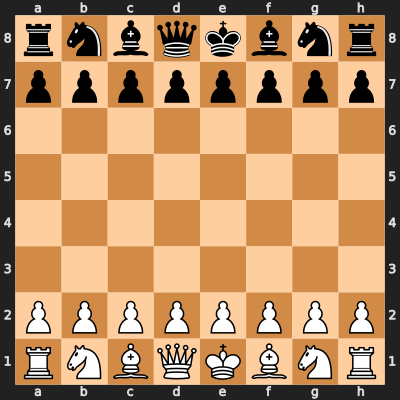


Move History:
Full history: 


In [6]:
if __name__ == "__main__":
    
    game = ChessGame()
    game.play_game(my_moves_generator)